# Double-Null Configurations
    - Negative and positive triangularity plasma source terms
    - Read source profiles internally or from the external profiles

In [1]:
import sys
import os

# Get current Python version
version = sys.version
print("Python Version:", version)

# Get current Python executable path
path = sys.executable
print("Python Path:", path)


Python Version: 3.9.5 (default, Jun  4 2021, 12:28:51) 
[GCC 7.5.0]
Python Path: /marconi/home/userexternal/klim0000/miniconda3/bin/python


In [2]:
import gbspy as g
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py

import multiprocessing as mp
from matplotlib.animation import FuncAnimation
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.ticker import AutoMinorLocator
import matplotlib.lines as mlines
from matplotlib.ticker import AutoMinorLocator
import re

#import sys  
#sys.path.insert(0, '/marconi/home/userexternal/klim0000/miniconda3/lib/python3.9/site-packages/gbs_python/gbspy')

# Get the current working directory|
cwd = os.getcwd()

# Simulations list

os.chdir('/marconi_scratch/userexternal/klim0000/GBS/DN_tria/delta_scan/DNT_dn0p6')
#os.chdir('/marconi_scratch/userexternal/klim0000/GBS/DN_tria/delta_scan/DPT_d0p6')
#os.chdir('/marconi_scratch/userexternal/klim0000/GBS/DN_tria/delta_scan/DPT_test')
#os.chdir('/marconi/home/userexternal/klim0000/scratch/GBS/DN_tria/st_scan/DPT_st0p3')


# Print the current working directory
print("Current working directory: {0}".format(cwd))

# Load GBS simulations

s=g.Sim()

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Current working directory: /marconi/home/userexternal/klim0000/jupyter_notebook/3_GBS_DN_Tria


## Source terms expression
    - Temperature = Source_flux_local (X), Source_tanh_local (O)
    - Density     = Source_flux_local (O), Source_tanh_local (X)

In [3]:
# For DN
with open('equilibrium') as f:
    lines = f.readlines()
    xmag_str=lines[-5]
    y0_source_str=lines[-4]
    Yxpt_str=lines[-3]
    Yxpt1_str=lines[-2]

    
# For SN
'''
with open('equilibrium') as f:
    lines = f.readlines()
    xmag_str=lines[-4]
    y0_source_str=lines[-3]
    Yxpt_str=lines[-2]
    #Yxpt1_str=lines[-2]
'''
    
xmag_split = xmag_str.split('=')
y0_source_split = y0_source_str.split('=')
Yxpt_split = Yxpt_str.split('=')
Yxpt1_split = Yxpt1_str.split('=')


xmag = float(xmag_split[1].strip())
y0_source = float(y0_source_split[1].strip())
Yxpt = float(Yxpt_split[1].strip())
Yxpt1 = float(Yxpt1_split[1].strip())

print("xmag=", xmag)
print("y0_source=", y0_source)
print("Yxpt=", Yxpt)
print("Yxpt1=", Yxpt1)

xmag= 216.0
y0_source= 400.0
Yxpt= 151.25
Yxpt1= 648.75


In [4]:
t_final = s.time[-1]
t_init = t_final# - 1 

tempe = s.get_field('Te', t1=t_init, t2=t_final)
dens = s.get_field('n', t1=t_init, t2=t_final)

tempe = np.mean(dens, axis=(2,3))
dens = np.mean(dens, axis=(2,3))

## Source input parameters

In [6]:
x0n = s.attribute['x0_EC_theta']
x0t = s.attribute['x0_EC_tempe']

#x0n = 90
#x0t = 90
print("The position of x0n and x0t =", x0n,"/", x0t)

wn = s.attribute['wEC_theta']
wt = s.attribute['wEC_tempe']

#wn = 1000
#wt = 2000

print("The width of wn and wt =", wn,"/", wt)

# Amplitude of the source
An = s.attribute['SEC_theta']
At = s.attribute['SEC_tempe']

print("The amplitude of An and At =", An,"/", At)

Psi = s.Psi
#psi0n = Psi[s.iy0, ix0n]
#psi0t = Psi[s.iy0, ix0t]

Bpol = s.dpsidx_v**2 + s.dpsidy_v**2
Xpt_coord = np.unravel_index(np.argmin(Bpol[Bpol > 0]), s.dpsidx_v.shape)
print(Xpt_coord)

The position of x0n and x0t = 140.0 / 160.0
The width of wn and wt = 500.0 / 500.0
The amplitude of An and At = 0.3 / 0.15
(63, 141)


# Compute source

In [7]:
print(s.nx, s.ny)
print(s.ixxpt, s.iyxpt)
print(np.shape(Psi))
iyxpt = s.iyxpt
iyxpt2 = s.ny-s.iyxpt
print(iyxpt, iyxpt2)
print(y0_source, xmag)

244 324
141 63
(324, 244)
63 261
400.0 216.0


In [8]:
for iy in range(0, s.ny-1):  # +1 since Python's range end is exclusive
    if s.y[iy] - y0_source <= 0 and s.y[iy + 1] - y0_source > 0:
        iysource = iy
        
# Search in xarray for ixsource
for ix in range(0, s.nx-1):
    if s.x[ix] - x0n - xmag <= 0 and s.x[ix + 1] - x0n - xmag > 0:
        ixsource_n = ix
        
for ix in range(0, s.nx-1):
    if s.x[ix] - x0n - xmag <= 0 and s.x[ix + 1] - x0n - xmag > 0:
        ixsource_t = ix
        

if iysource is not None and ixsource_n and ixsource_t is not None:
    psi_eq_n = Psi[iysource][ixsource_n]
    psi_eq_t = Psi[iysource][ixsource_t]

In [9]:
# Density source (Local flux)
Sn = [[0 for x in range(s.nx)] for y in range(s.ny)]
St = [[0 for x in range(s.nx)] for y in range(s.ny)]

for i in range(s.ny):
    for j in range(s.nx):
        if (s.y[i] > Yxpt) and (s.y[i]< Yxpt1):
            Sn[i][j]= An * np.exp(-(Psi[i][j] - psi_eq_n)**2/wn**2) 
            #Sn[i][j] = An/2 * (np.tanh(-(Psi[i][j] - psi_eq_n)/1500) + 1)
            St[i][j] = At/2 * (np.tanh(-(Psi[i][j] - psi_eq_t)/wt) + 1)
        else:
            Sn[i][j] = 0
            St[i][j] = 0

# Power source
Sp = dens * St + tempe * Sn

In [10]:
#### Save source profiles in hdf5
'''
from gbspy.sources import write_const_plasma_sources
write_const_plasma_sources("DN_NT_sources", theta=Sn, tempe=St, tempi=St, shape=(80,324,244), filemode="w-")
DN_NT = np.mean(DN_NT_source, axis=0)
'''

'\nfrom gbspy.sources import write_const_plasma_sources\nwrite_const_plasma_sources("DN_NT_sources", theta=Sn, tempe=St, tempi=St, shape=(80,324,244), filemode="w-")\nDN_NT = np.mean(DN_NT_source, axis=0)\n'

# Plot figure

Text(0, 0.5, '$Z\\, [\\rho_{s0}]$')

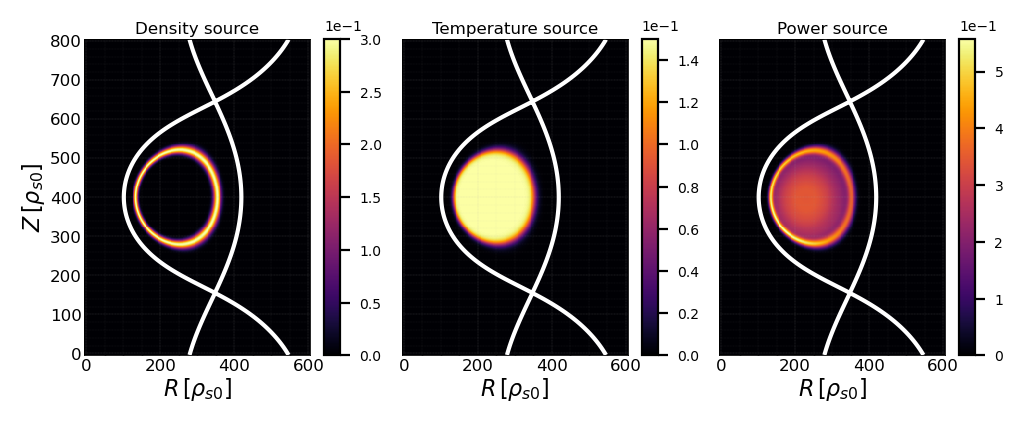

In [11]:
X, Y = np.meshgrid(s.x, s.y)
fig, axes = plt.subplots(ncols=3,  figsize=(5, 2),  dpi=200, sharey=True, constrained_layout=True)

cmap = 'inferno' # gist_heat, inferno, magma, plasma, viridis, bwr, seismic
cs  = axes[0].pcolormesh(X, Y, Sn, cmap=cmap)
cs2 = axes[1].pcolormesh(X, Y, St, cmap=cmap)
cs3 = axes[2].pcolormesh(X, Y, Sp, cmap=cmap)

axes[0].set_title('Density source', size=6, pad=2)
axes[1].set_title('Temperature source', size=6, pad=2)
axes[2].set_title('Power source', size=6, pad=2)

cbar1=fig.colorbar(cs,  ax=axes[0], pad=0)
cbar2=fig.colorbar(cs2, ax=axes[1], pad=0)
cbar3=fig.colorbar(cs3, ax=axes[2], pad=0)
cbar1.ax.tick_params(labelsize=5); cbar2.ax.tick_params(labelsize=5); cbar3.ax.tick_params(labelsize=5) 

# Colorbar unit in scientific notation
#cbar1.formatter.set_powerlimits((0, 0))

cbar1.formatter.set_powerlimits((0, 0))
cbar2.formatter.set_powerlimits((0, 0))
cbar3.formatter.set_powerlimits((0, 0))

cbar1.ax.yaxis.set_offset_position('left')
cbar2.ax.yaxis.set_offset_position('left')
cbar3.ax.yaxis.set_offset_position('left')

# Colorbar yaxis scientific notation fontsize
cbar1.ax.yaxis.get_offset_text().set_fontsize(5)
cbar2.ax.yaxis.get_offset_text().set_fontsize(5)
cbar3.ax.yaxis.get_offset_text().set_fontsize(5)

axes[0].contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]],colors='w')
axes[1].contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]],colors='w')
axes[2].contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]],colors='w')

for ax in axes:
    ax.grid(True, which='major', alpha=1., linestyle=':', linewidth=0.1)
    ax.grid(True, which='minor', alpha=0.4, linestyle=':', linewidth=0.1)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(axis='x', labelsize=6, pad=1)
    ax.tick_params(axis='y', labelsize=6, pad=1)
    ax.tick_params(which='minor', direction="in", size=0.2)
    ax.tick_params(which='major', direction="in", size=0.5)
    #ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax.spines["bottom"].set_linewidth(0.3)
    ax.spines["left"].set_linewidth(0.3)
    ax.spines["right"].set_linewidth(0.3)
    ax.spines["top"].set_linewidth(0.3)
    ax.set_xlabel(r'$R \,[\rho_{s0}]$', fontsize=8, labelpad=1)
    #ax.legend(bbox_to_anchor=(0.35, 1), loc='upper right', edgecolor='white', prop={'size': 2}, facecolor='white' )

axes[0].set_ylabel(r'$Z\, [\rho_{s0}]$', fontsize=8, rotation=90, labelpad=1)
#plt.gca().set_aspect('equal')
#plt.show(block=False)

#plt.savefig("/marconi/home/userexternal/klim0000/DN_NT_source.png", bbox_inches='tight', pad_inches = 0.01, dpi=1200)